# Plotting Glider data with Python tools

In this notebook we demonstrate how to obtain and plot glider data using iris and cartopy. We will explore data from the Rutgers University RU29 [Challenger](http://challenger.marine.rutgers.edu) glider that was launched from Ubatuba, Brazil on June 23, 2015 to travel across the Atlantic Ocean. After 282 days at sea, the Challenger was picked up off the coast of South Africa, on March 31, 2016. For more information on this ground breaking excusion see: [https://marine.rutgers.edu/main/announcements/the-challenger-glider-mission-south-atlantic-mission-complete](https://marine.rutgers.edu/main/announcements/the-challenger-glider-mission-south-atlantic-mission-complete)

Data collected from this glider mission are available on the IOOS Glider DAC THREDDS via OPeNDAP.

In [1]:
url = ('https://data.ioos.us/thredds/dodsC/deployments/rutgers/'
       'ru29-20150623T1046/ru29-20150623T1046.nc3.nc')

In [2]:
import iris

iris.FUTURE.netcdf_promote = True

glider = iris.load(url)

print(glider)

0: precise_time Variable Quality Flag / (1) (-- : 1; -- : 542; -- : 483)
1: lat_uv Variable Quality Flag / (1)  (-- : 1; -- : 542; -- : 483)
2: u Variable Quality Flag / (1)       (-- : 1; -- : 542; -- : 483)
3: Platform Metadata / (1)             (-- : 1; -- : 542; -- : 483)
4: time_uv Variable Quality Flag / (1) (-- : 1; -- : 542; -- : 483)
5: lat Variable Quality Flag / (1)     (-- : 1; -- : 542; -- : 483)
6: Trajectory Name / (1)               (-- : 1; -- : 64)
7: Profile ID / (1)                    (-- : 1; -- : 542)
8: WMO ID / (1)                        (-- : 1; -- : 64)
9: lon_uv Variable Quality Flag / (1)  (-- : 1; -- : 542; -- : 483)
10: latitude Variable Quality Flag / (1) (-- : 1; -- : 542; -- : 483)
11: precise_lon Variable Quality Flag / (1) (-- : 1; -- : 542; -- : 483)
12: longitude Variable Quality Flag / (1) (-- : 1; -- : 542; -- : 483)
13: v Variable Quality Flag / (1)       (-- : 1; -- : 542; -- : 483)
14: CTD Metadata / (1)                  (-- : 1; -- : 542; -- : 

/home/filipe/miniconda3/envs/IOOS/lib/python3.5/site-packages/iris/fileformats/cf.py:280: UserWarning: Missing CF-netCDF ancillary data variable 'lat_qc', referenced by netCDF variable 'precise_lat'
  warnings.warn(message % (name, nc_var_name))
/home/filipe/miniconda3/envs/IOOS/lib/python3.5/site-packages/iris/fileformats/cf.py:280: UserWarning: Missing CF-netCDF ancillary data variable 'lon_qc', referenced by netCDF variable 'precise_lon'
  warnings.warn(message % (name, nc_var_name))


`Iris` requires the data to adhere strictly to the `CF-1.6` data model.
That is why we see all those warnings about `Missing CF-netCDF ancillary data variable`.
 Note that if the data is not CF at all `iris` will refuse to load it!

The other hand, the advantage of following the `CF-1.6` conventions,
is that the `iris` cube has the proper metadata is attached it.
We do not need to extract the coordinates or any other information separately .
All we need to do is to request the phenomena we want, in this case `sea_water_density`, `sea_water_temperature` and `sea_water_salinity`.

In [3]:
temp = glider.extract_strict('sea_water_temperature')
salt = glider.extract_strict('sea_water_salinity')
dens = glider.extract_strict('sea_water_density')

print(temp)

sea_water_temperature / (Celsius)   (-- : 1; -- : 542; -- : 483)
     Auxiliary coordinates:
          latitude                      x       x         -
          longitude                     x       x         -
          time                          x       x         -
          depth                         x       x         x
     Attributes:
          Conventions: Unidata Dataset Discovery v1.0, COARDS, CF-1.6
          DODS.dimName: wmo_id_strlen
          DODS.strlen: 7
          Easternmost_Easting: 13.5917595008
          Metadata_Conventions: Unidata Dataset Discovery v1.0, COARDS, CF-1.6
          Northernmost_Northing: -25.4926697853
          Southernmost_Northing: -37.3408904
          Westernmost_Easting: -44.9219533843
          _ChunkSize: 1
          acknowledgment: This deployment supported by funding from the G.  Unger Vetelsen Foundation...
          actual_range: [  3.744   24.5387]
          cdm_data_type: TrajectoryProfile
          cdm_profile_variables: time_

Glider data is not something trivial to visualize. The very first thing to do is to plot the glider track to check its path.

In [4]:
import numpy.ma as ma

T = temp.data.squeeze()
S = salt.data.squeeze()
D = dens.data.squeeze()

x = temp.coord(axis='X').points.squeeze()
y = temp.coord(axis='Y').points.squeeze()
z = temp.coord(axis='Z')
t = temp.coord(axis='T')

vmin, vmax = z.attributes['actual_range']

z = ma.masked_outside(z.points.squeeze(), vmin, vmax)
t = t.units.num2date(t.points.squeeze())

location = y.mean(), x.mean()  # Track center.
locations = list(zip(y, x))  # Track points.

In [5]:
import folium

tiles = ('http://services.arcgisonline.com/arcgis/rest/services/'
         'World_Topo_Map/MapServer/MapServer/tile/{z}/{y}/{x}')

m = folium.Map(
    location,
    tiles=tiles,
    attr='ESRI',
    zoom_start=4
)

folium.CircleMarker(locations[0], fill_color='green', radius=10).add_to(m)
folium.CircleMarker(locations[-1], fill_color='red', radius=10).add_to(m)

line = folium.PolyLine(
    locations=locations,
    color='orange',
    weight=8,
    opacity=0.6,
    popup='Slocum Glider ru29 Deployed on 2015-06-23'
).add_to(m)

m

One might be interested in a the individual profiles of each dive. Lets extract the deepest dive and plot it.

In [6]:
import numpy as np

# Find the deepest profile.
idx = np.nonzero(~T[:, -1].mask)[0][0]

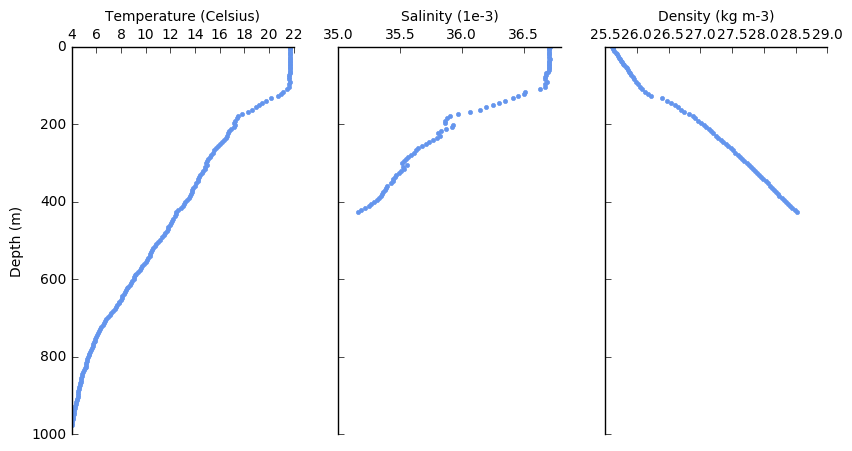

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

ncols = 3
fig, (ax0, ax1, ax2) = plt.subplots(
    sharey=True, sharex=False, ncols=ncols, figsize=(3.25*ncols, 5)
)

kw = dict(linewidth=2, color='cornflowerblue', marker='.')
ax0.plot(T[idx], z[idx], **kw)
ax1.plot(S[idx], z[idx], **kw)
ax2.plot(D[idx]-1000, z[idx], **kw)


def spines(ax):
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')


[spines(ax) for ax in (ax0, ax1, ax2)]

ax0.set_ylabel('Depth (m)')
ax0.set_xlabel('Temperature ({})'.format(temp.units))
ax0.xaxis.set_label_position('top')

ax1.set_xlabel('Salinity ({})'.format(salt.units))
ax1.xaxis.set_label_position('top')

ax2.set_xlabel('Density ({})'.format(dens.units))
ax2.xaxis.set_label_position('top')

ax0.invert_yaxis()

We can also visualize the whole track as a cross-section.

In [8]:
import numpy as np
import seawater as sw
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


def distance(x, y, units='km'):
    dist, pha = sw.dist(x, y, units=units)
    return np.r_[0, np.cumsum(dist)]


def plot_glider(x, y, z, t, data, cmap=plt.cm.viridis,
                figsize=(9, 3.75), track_inset=False):

    fig, ax = plt.subplots(figsize=figsize)
    dist = distance(x, y, units='km')
    z = np.abs(z)
    dist, z = np.broadcast_arrays(dist[..., np.newaxis], z)
    cs = ax.pcolor(dist, z, data, cmap=cmap, snap=True)
    kw = dict(orientation='vertical', extend='both', shrink=0.65)
    cbar = fig.colorbar(cs, **kw)

    if track_inset:
        axin = inset_axes(ax, width="25%", height="30%", loc=4)
        axin.plot(x, y, 'k.')
        start, end = (x[0], y[0]), (x[-1], y[-1])
        kw = dict(marker='o', linestyle='none')
        axin.plot(*start, color='g', **kw)
        axin.plot(*end, color='r', **kw)
        axin.axis('off')

    ax.invert_yaxis()
    ax.set_xlabel('Distance (km)')
    ax.set_ylabel('Depth (m)')
    return fig, ax, cbar

Data collected from 2015-06-23 10:57:59 to 2016-03-31 09:25:31


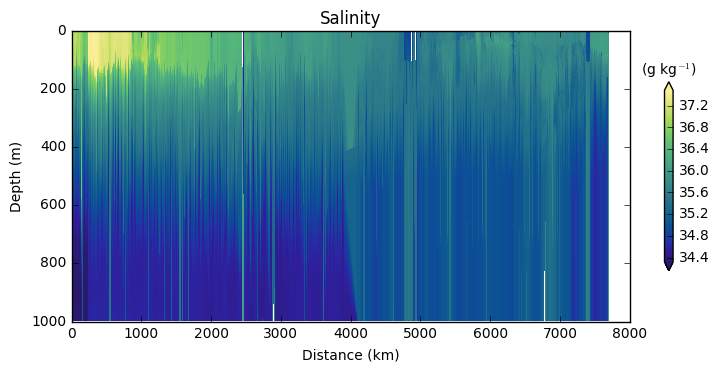

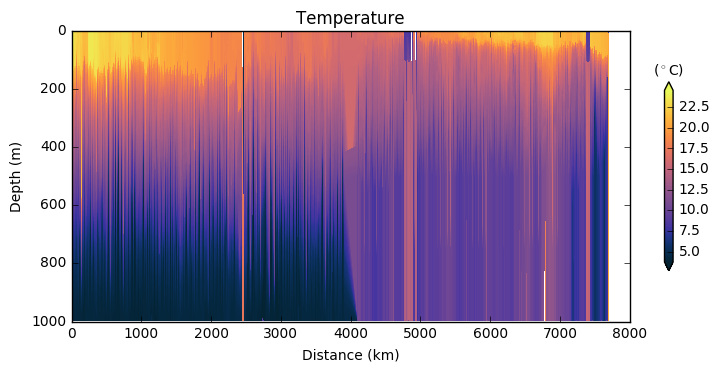

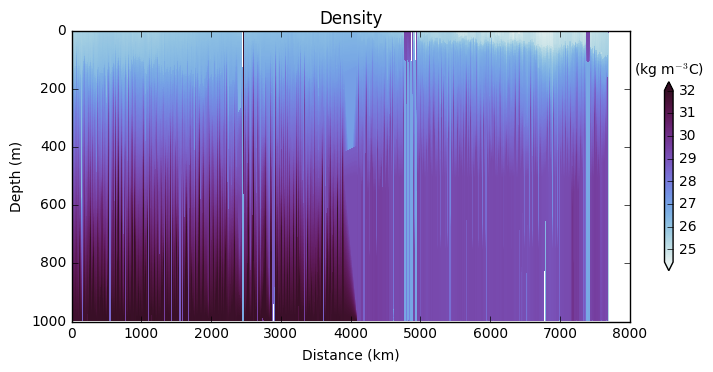

In [9]:
import cmocean

fig, ax, cbar = plot_glider(x, y, z, t, S,
                            cmap=cmocean.cm.haline, track_inset=False)
cbar.ax.set_xlabel('(g kg$^{-1}$)')
cbar.ax.xaxis.set_label_position('top')
ax.set_title('Salinity')

fig, ax, cbar = plot_glider(x, y, z, t, T,
                            cmap=cmocean.cm.thermal, track_inset=False)
cbar.ax.set_xlabel(r'($^\circ$C)')
cbar.ax.xaxis.set_label_position('top')
ax.set_title('Temperature')

fig, ax, cbar = plot_glider(x, y, z, t, D-1000,
                            cmap=cmocean.cm.dense, track_inset=False)
cbar.ax.set_xlabel(r'(kg m$^{-3}$C)')
cbar.ax.xaxis.set_label_position('top')
ax.set_title('Density')

print('Data collected from {} to {}'.format(t[0], t[-1]))

Glider cross-section also very be useful but we need to be careful when interpreting those due to the many turns the glider took,
and the time it took to complete the track.

Note that the `x-axis` can be either time or distance. Note that this particular track took ~281 days to complete!

<br>
Right click and choose Save link as... to
[download](https://raw.githubusercontent.com/ioos/notebooks_demos/master/notebooks/2016-11-15-glider_data_example.ipynb)
this notebook, or see a static view [here](http://nbviewer.ipython.org/urls/raw.githubusercontent.com/ioos/notebooks_demos/master/notebooks/2016-11-15-glider_data_example.ipynb).